In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from typing import List
import seaborn as sns

### Đọc toàn bộ dữ liệu

Chuyển dữ liệu năm sản xuất sang tuổi xe

In [40]:
dataset = pd.read_pickle('data/train/cars.pkl')
dataset["Năm sản xuất"] = 2024 - dataset["Năm sản xuất"]
dataset.rename(columns={"Năm sản xuất": "Tuối xe"}, inplace=True)
print(dataset.shape)
dataset.head()

(25582, 15)


,Tên hãng xe,Tuối xe,Tỉnh,Số Km đã đi,Xuất xứ,Kiểu dáng,Hộp số,Màu ngoại thất,Màu nội thất,Số chỗ ngồi,Số cửa,Dẫn động,Loại động cơ,Dung tích,Giá
0,audi,4,TP HCM,30.0,Nhập khẩu,Sedan,Số tự động,Đen,Đen,5,4,AWD,Xăng,3.0,2950.0
1,audi,10,Hà Nội,94.0,Nhập khẩu,Sedan,Số tự động,Xanh,Nâu,5,4,FWD,Xăng,2.0,560.0
2,audi,8,TP HCM,50.0,Nhập khẩu,Sedan,Số tự động,Đen,Đen,5,4,FWD,Xăng,2.0,690.0
3,audi,8,Hà Nội,76.0,Nhập khẩu,Crossover,Số tự động,Xanh,Đen,5,5,AWD,Xăng,2.0,699.0
4,audi,8,Hà Nội,90.0,Nhập khẩu,SUV,Số tự động,Trắng,Kem,5,5,AWD,Xăng,2.0,739.0


Khai báo seed, test size để chia dữ liệu huấn luyện, kiểm thử giống nhau

In [41]:
from sklearn.model_selection import train_test_split

SPLIT_SEED = 10
TEST_SIZE = 0.25

def get_train_test_dataset(df: pd.DataFrame):
    X = df.drop(columns=["Giá"], axis=1)
    y = df['Giá']
    return train_test_split(X, y, test_size=TEST_SIZE, random_state=SPLIT_SEED)

### Thiết kế hàm đánh giá mô hình dự đoán giá trị

- Sử dụng 3 metrics chính để đánh giá sự hiệu quả của mô hình dự đoán:
1. Mean Squared Error (MSE): Trung bình bình phương sai số, MSE càng nhỏ, mô hình càng tốt
2. Mean Absolute Error (MAE): Trung bình giá trị tuyệt đối sai số. MAE càng nhỏ, mô hình càng tốt
3. $R^2$ Score: Hệ số xác định, thể hiện mức độ phù hợp của mô hình với dữ liệu, giá trị nằm trong khoảng (0, 1)
$R^2 = 1 - \frac{SSR}{TSS}$ với SSR(sum of squared residuals): tổng bình phương sai số, và TSS(total sum of squares): tổng bình phương sự khác biệt giá trị thực tế và giá trị trung bình, $R^2 Score$ càng gần 1, thì mô hình giải thích tốt sự biến đổi trong dữ liệu
4. Max Error: Sai số lớn nhất

In [42]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error

def evaluate(y_pred, y_test):
    np.set_printoptions(precision=0)
    values = np.concatenate((y_pred.reshape(-1, 1), y_test.reshape(-1, 1)), 1)
    print(values)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    max_err = max_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")
    print(f"Max Error: {max_err}")

    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
    plt.show()
    return mse, mae, r2, max_err

### Chuẩn hóa dữ liệu danh mục
Số hóa dữ liệu danh mục theo tần suất xuất hiện thay vì sử dụng LabelEncoder ngẫu nhiên \
Dữ liệu có tần suất cao gán nhãn là 0, và tăng dần nhãn theo chiều giảm dần của tần suất dữ liệu

In [43]:
def encode_label_frequent(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    for col in columns:
        mapping = {}
        for idx, e in enumerate(list(df[col].value_counts().index)):
            mapping[e] = idx
        df[col] = df[col].map(mapping)
    return df

### Phân tích tương quan giữa các cột

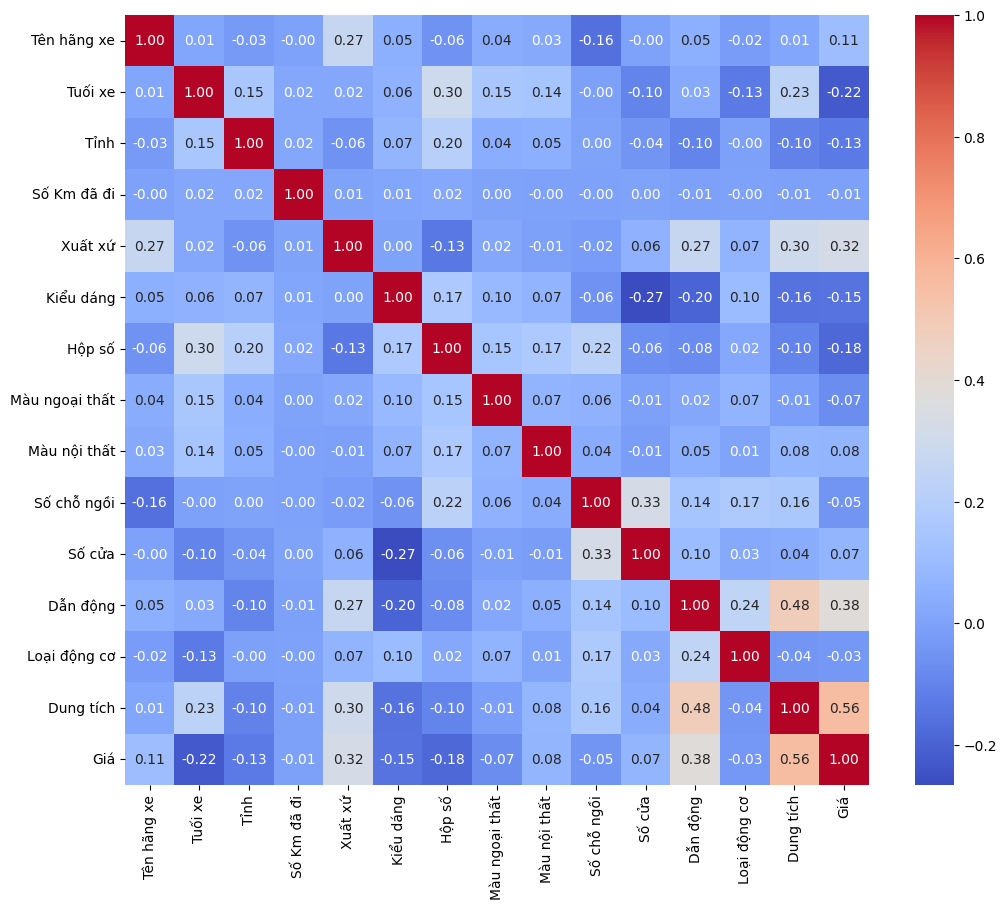

In [44]:
corr_matrix = encode_label_frequent(
    dataset, 
    columns=["Tên hãng xe", "Tỉnh", "Xuất xứ", "Kiểu dáng", "Hộp số", "Màu ngoại thất", "Màu nội thất", "Dẫn động", "Loại động cơ"]
).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

### Chia tập dữ liệu huấn luyện, kiểm thử

In [45]:
X_train, X_test, y_train, y_test = get_train_test_dataset(
    encode_label_frequent(
        dataset, 
        columns=["Tên hãng xe", "Tỉnh", "Xuất xứ", "Kiểu dáng", "Hộp số", "Màu ngoại thất", "Màu nội thất", "Dẫn động", "Loại động cơ"]
    )
)
print(len(X_train), len(X_test))
X_train

19186 6396


,Tên hãng xe,Tuối xe,Tỉnh,Số Km đã đi,Xuất xứ,Kiểu dáng,Hộp số,Màu ngoại thất,Màu nội thất,Số chỗ ngồi,Số cửa,Dẫn động,Loại động cơ,Dung tích
7917,2,6,0,68.000,0,2,0,0,1,5,5,0,0,2.0
5120,7,1,1,7.666,0,0,0,0,0,7,5,0,0,1.5
22887,0,4,16,68.468,0,2,1,0,3,8,5,1,0,2.0
6362,2,3,1,71.000,0,2,0,0,1,5,5,0,0,2.0
20936,0,0,0,0.000,1,2,0,0,2,8,5,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9699,4,9,1,80.000,0,5,0,6,1,7,5,0,0,3.3
7567,2,0,0,0.000,0,2,0,1,0,5,5,0,0,2.0
18272,6,6,18,70.000,1,3,0,9,0,5,4,3,1,2.4
7570,2,2,0,38.000,0,0,0,3,2,7,5,2,1,2.2


### Thiết kế baseline bằng mô hình Linear Regression đơn giản

Huấn luyện mô hình Linear Regression trên tập dữ liệu huấn luyện: X_train, y_train

[[1915. 2459.]
 [1585. 2950.]
 [-220.  165.]
 ...
 [ 852.  290.]
 [1717.  748.]
 [2740. 3550.]]
Mean Squared Error: 1357776.2756280582
Mean Absolute Error: 686.3490089662083
R^2 Score: 0.5104647322266529
Max Error: 11097.590447906758


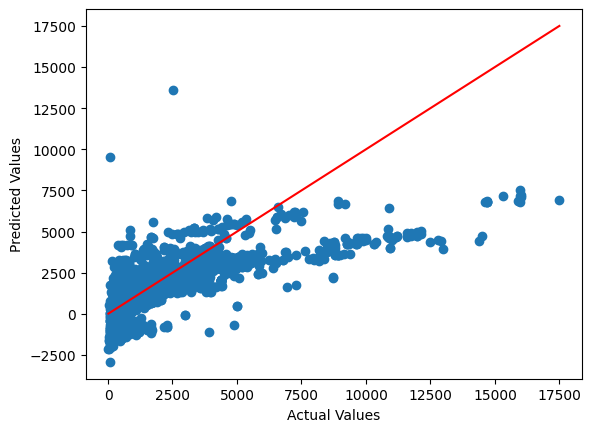

In [46]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

### Lasso Regression (L1 Regularization)

[[1915. 2459.]
 [1586. 2950.]
 [-221.  165.]
 ...
 [ 852.  290.]
 [1717.  748.]
 [2739. 3550.]]
Mean Squared Error: 1357794.5334639063
Mean Absolute Error: 686.2675371380785
R^2 Score: 0.5104581495114284
Max Error: 11094.387389866613


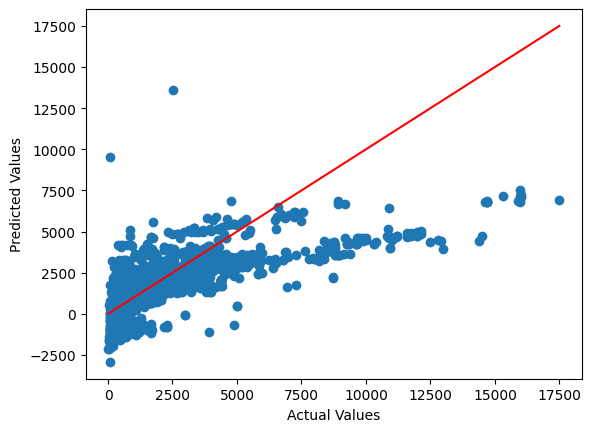

In [9]:
from sklearn.linear_model import Lasso

regressor = Lasso(alpha=0.1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

### Ridge Regression (L2 Rugularization)

[[1915. 2459.]
 [1585. 2950.]
 [-220.  165.]
 ...
 [ 852.  290.]
 [1717.  748.]
 [2740. 3550.]]
Mean Squared Error: 1357776.9292657466
Mean Absolute Error: 686.3469529009719
R^2 Score: 0.5104644965628645
Max Error: 11097.423768071047


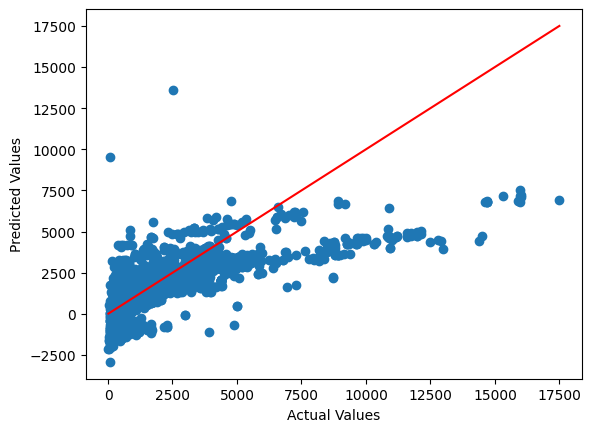

In [10]:
from sklearn.linear_model import Ridge

regressor = Ridge(alpha=0.1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

## Decision Tree Regression

[[1814. 2459.]
 [1379. 2950.]
 [ 125.  165.]
 ...
 [ 295.  290.]
 [ 979.  748.]
 [3550. 3550.]]
Mean Squared Error: 122856.39039291722
Mean Absolute Error: 84.00594852468835
R^2 Score: 0.9557051209037779
Max Error: 14225.0


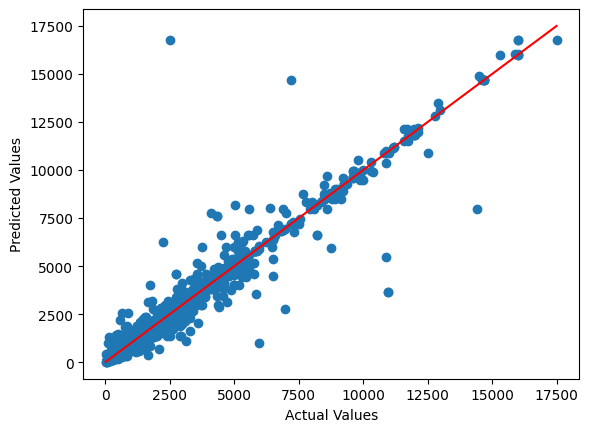

0.998804466481513
0.9557051209037779


In [11]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

_ = evaluate(y_pred, y_test.values)
print(regressor.score(X_train, y_train))
print(regressor.score(X_test, y_test))

## Random Forest Regression

[[1865. 2459.]
 [1644. 2950.]
 [ 152.  165.]
 ...
 [ 398.  290.]
 [ 919.  748.]
 [3549. 3550.]]
Mean Squared Error: 94702.04709131284
Mean Absolute Error: 79.44636438601594
R^2 Score: 0.9658559419444227
Max Error: 12445.461428571429


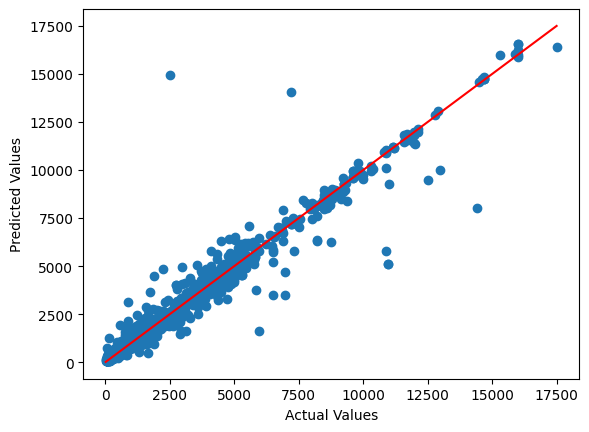

0.9941358381355139
0.9658559419444227


In [12]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

_ = evaluate(y_pred, y_test.values)
print(regressor.score(X_train, y_train))
print(regressor.score(X_test, y_test))

Tối ưu hóa Random Forest bằng GridSearch

In [13]:
from sklearn.model_selection import GridSearchCV
# params = {
#     "criterion": ["squared_error", "friedman_mse", "poisson"],
#     "max_depth": [None, 10, 20, 50],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 5, 15],
#     "max_features": ["sqrt", "log2", None]
# }
# regressor = RandomForestRegressor(random_state=1, n_estimators=100)

# optimizer = GridSearchCV(regressor, params, n_jobs=-1, scoring="neg_mean_squared_error", verbose=1)
# optimizer.fit(X_train.values, y_train.values)

# print(optimizer.best_params_)
# y_pred = optimizer.predict(X_test)
# _ = evaluate(y_pred, y_test.values)

## K-Nearest Neighbors (KNN)

In [14]:
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

preprocessor = make_column_transformer(
    (StandardScaler(), ['Số Km đã đi']),
    remainder='passthrough'
)

pipeline = make_pipeline(preprocessor, KNeighborsRegressor(n_neighbors=5))

pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Số Km đã đi'])])),
                ('kneighborsregressor', KNeighborsRegressor())])

[[1980. 2459.]
 [ 950. 2950.]
 [ 153.  165.]
 ...
 [ 550.  290.]
 [ 918.  748.]
 [3470. 3550.]]
Mean Squared Error: 296808.0217636022
Mean Absolute Error: 173.7950594121326
R^2 Score: 0.8929882654312008
Max Error: 11652.2


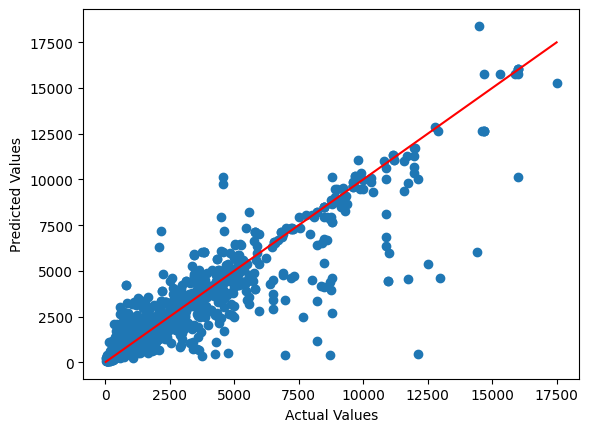

0.9349449930267875
0.8929882654312008


In [15]:
y_pred = pipeline.predict(X_test)

_ = evaluate(y_pred, y_test.values)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))

In [16]:
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import GridSearchCV

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# regressor = KNeighborsRegressor()
# params = {
#     "n_neighbors": range(1, 10),
#     "weights": ["uniform", "distance"],
#     "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
#     "p": [1, 2, 3, 5]
# }

# optimizer = GridSearchCV(regressor, params, cv=10, n_jobs=-1, verbose=2)
# optimizer.fit(scaler.fit_transform(X_train), y_train)

# print("Best Params:", optimizer.best_params_)
# y_pred = optimizer.predict(scaler.transform(X_test))
# _ = evaluate(y_pred, y_test.values)

## Support Vector Regression

[[ 746. 2459.]
 [ 723. 2950.]
 [ 502.  165.]
 ...
 [ 391.  290.]
 [ 609.  748.]
 [ 945. 3550.]]
Mean Squared Error: 2814458.019482617
Mean Absolute Error: 675.5452646335067
R^2 Score: -0.014730103136437078
Max Error: 16472.832427916288


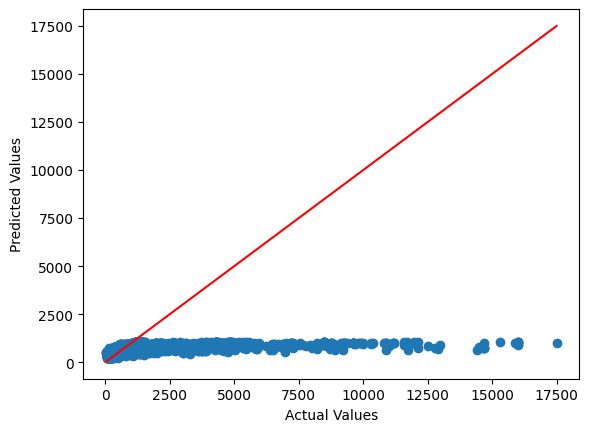

-0.017880585249471448
-0.014730103136437078


In [17]:
from sklearn.svm import SVR

preprocessor = make_column_transformer(
    (StandardScaler(), ["Số Km đã đi"]), remainder="passthrough"
)

pipeline = make_pipeline(preprocessor, SVR())

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
_ = evaluate(y_pred, y_test.values)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))

Tối ưu tham số SVR

In [18]:
# from sklearn.model_selection import GridSearchCV

# params = {
#     "svr__C": [100],
#     "svr__epsilon": [1],
#     "svr__gamma": ["auto"],
# }

# optimizer = GridSearchCV(pipeline, params, cv=5, scoring="neg_mean_squared_error", verbose=2, n_jobs=-1)

# optimizer.fit(X_train, y_train)

# print(optimizer.best_params_)

[[1585. 2459.]
 [2131. 2950.]
 [ 486.  165.]
 ...
 [ 471.  290.]
 [ 826.  748.]
 [3718. 3550.]]
Mean Squared Error: 1208840.5721849678
Mean Absolute Error: 323.01543233316966
R^2 Score: 0.5641622969689002
Max Error: 15109.741342168256


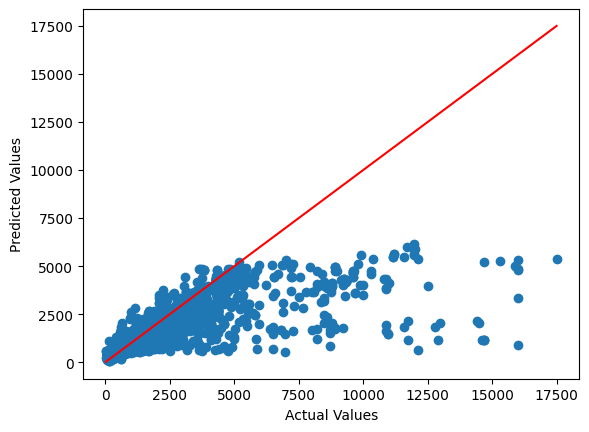

0.5917648012814682
0.5641622969689002


In [19]:
pipeline = make_pipeline(preprocessor, SVR(C=100, epsilon=1, gamma='auto'))
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

_ = evaluate(y_pred, y_test.values)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))

## Gradient Boosting Regression

[[2238. 2459.]
 [1464. 2950.]
 [  -9.  165.]
 ...
 [ 645.  290.]
 [ 972.  748.]
 [2836. 3550.]]
Mean Squared Error: 196806.01319218334
Mean Absolute Error: 235.61875686943742
R^2 Score: 0.929043181784219
Max Error: 8788.809086232573


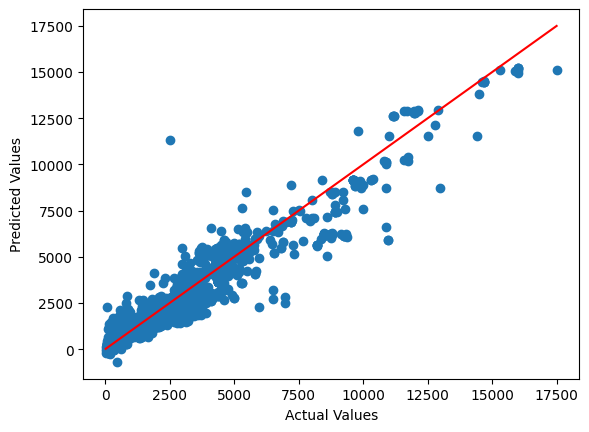

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

### Bagging

[[1861. 2459.]
 [1659. 2950.]
 [ 153.  165.]
 ...
 [ 388.  290.]
 [ 920.  748.]
 [3550. 3550.]]
Mean Squared Error: 96021.94296949766
Mean Absolute Error: 79.83764913097303
R^2 Score: 0.9653800641479416
Max Error: 12575.418095238098


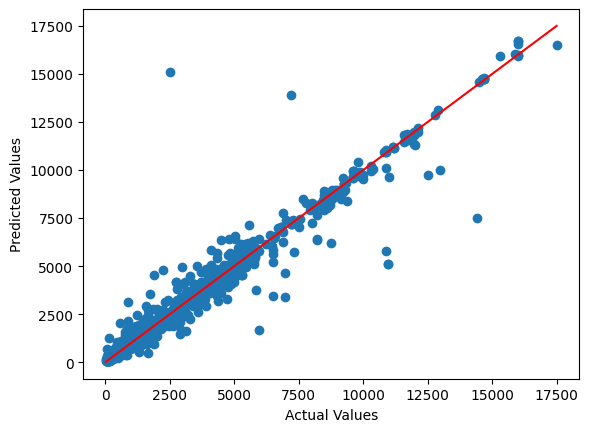

In [21]:
from sklearn.ensemble import BaggingRegressor

regressor = DecisionTreeRegressor()
bagging = BaggingRegressor(estimator=regressor, n_estimators=100, random_state=0)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)
_ = evaluate(y_pred, y_test.values)

## Bayes Regression

[[1914. 2459.]
 [1586. 2950.]
 [-221.  165.]
 ...
 [ 853.  290.]
 [1718.  748.]
 [2739. 3550.]]
Mean Squared Error: 1357841.290454706
Mean Absolute Error: 686.149453920829
R^2 Score: 0.5104412916561085
Max Error: 11081.391384555849


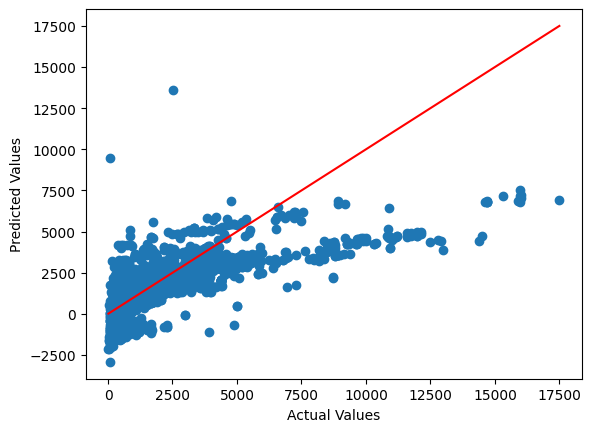

In [22]:
from sklearn.linear_model import BayesianRidge
regressor = BayesianRidge()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

_ = evaluate(y_pred, y_test.values)

## Hồi quy Dirichlet Process

## Hồi quy Gaussian Process

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor



## AdaBoost

## XGBoost

In [24]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

regressor = XGBRegressor(objective="reg:squarederror")
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(regressor, X_train, y_train, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1, error_score='raise')
regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

[[1840. 2459.]
 [1762. 2950.]
 [ 162.  165.]
 ...
 [ 621.  290.]
 [ 893.  748.]
 [3359. 3550.]]
Mean Squared Error: 83616.98031712929
Mean Absolute Error: 104.72303897869295
R^2 Score: 0.9698525732223372
Max Error: 10591.998779296875


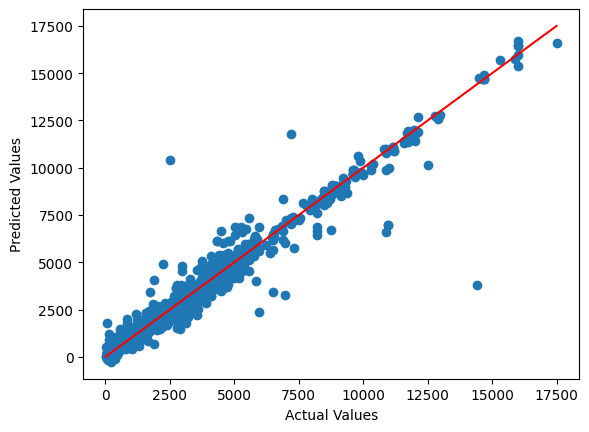

In [25]:
y_pred = regressor.predict(X_test)

_ = evaluate(y_pred, y_test.values)

## Áp dụng phương pháp giảm chiều dữ liều

### PCA: Principal Component Analysis

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)
pca.fit_transform(X_train)

array([[-4.e+01, -2.e+00, -3.e+00, ...,  2.e-01, -5.e-01, -3.e-01],
       [-1.e+02, -3.e+00,  1.e+00, ..., -7.e-02,  4.e-02, -3.e-01],
       [-4.e+01,  1.e+01, -5.e+00, ..., -1.e-01, -5.e-02, -6.e-01],
       ...,
       [-4.e+01,  2.e+01,  2.e+00, ..., -6.e-01,  3.e-01,  3.e-01],
       [-7.e+01, -3.e+00, -3.e+00, ..., -7.e-01,  1.e-01,  3.e-02],
       [ 5.e+01, -2.e+00,  1.e+00, ..., -7.e-01,  2.e-01, -3.e-01]])

[[2969. 2459.]
 [1822. 2950.]
 [ 268.  165.]
 ...
 [ 414.  290.]
 [ 929.  748.]
 [3543. 3550.]]
Mean Squared Error: 162744.97116265004
Mean Absolute Error: 106.5017060683559
R^2 Score: 0.9413236153356551
Max Error: 14027.974857142857


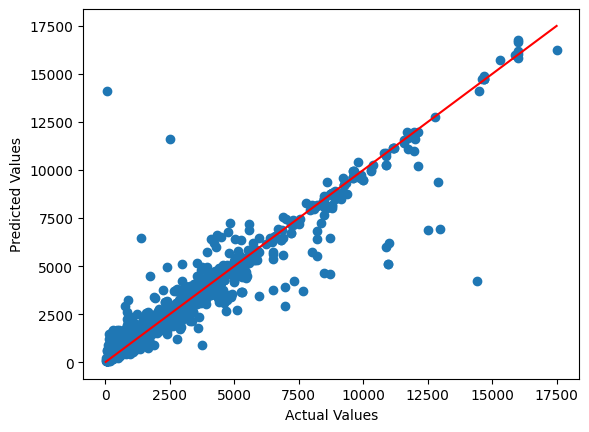

In [27]:
regressor = RandomForestRegressor()
regressor.fit(pca.fit_transform(X_train), y_train.values)
y_pred = regressor.predict(pca.transform(X_test))

_ = evaluate(y_pred, y_test.values)

### LDA: Linear Discriminant Analysis 

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=10)
lda.fit_transform(X_train, y_train)

array([[ 1.,  0.,  0., ...,  1., -2.,  0.],
       [-0.,  1., -0., ..., -0., -0.,  1.],
       [ 2., -1.,  0., ...,  1., -0.,  0.],
       ...,
       [-1., -0., -0., ...,  1.,  2., -1.],
       [-2.,  2., -0., ...,  0.,  0.,  1.],
       [ 2., -3.,  0., ...,  1.,  1., -1.]])

[[2024. 2459.]
 [1655. 2950.]
 [ 151.  165.]
 ...
 [ 402.  290.]
 [ 918.  748.]
 [3575. 3550.]]
Mean Squared Error: 137199.5588750939
Mean Absolute Error: 101.53848817415734
R^2 Score: 0.9505338073746822
Max Error: 14906.45352380952


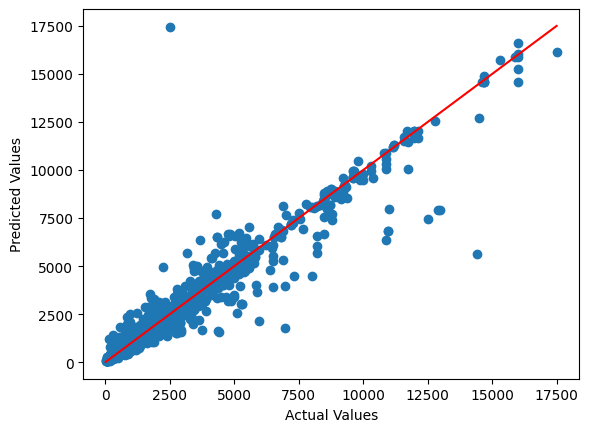

In [29]:
regressor = RandomForestRegressor()
regressor.fit(lda.fit_transform(X_train, y_train), y_train.values)
y_pred = regressor.predict(lda.transform(X_test))

_ = evaluate(y_pred, y_test.values)